In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

In [2]:
movies = pd.read_csv("./ml-latest-small/movies.csv")

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [6]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [7]:
movies.duplicated().sum()

np.int64(0)

In [8]:
def extract_year(title):
    match = re.search(r"\((\d{4})\)", title) 
    return int(match.group(1)) if match else None

In [9]:
movies['year'] = movies['title'].apply(extract_year)

In [10]:
movies['clean_title'] = movies['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))

In [11]:
movies.head(3)

,movieId,title,genres,year,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men


In [12]:
movies['year'].isnull().sum()

np.int64(13)

In [13]:
movies.shape

(9742, 5)

In [14]:
movies =movies.dropna(subset = ['year'])

In [15]:
len(movies)

9729

## Number of Movies per year

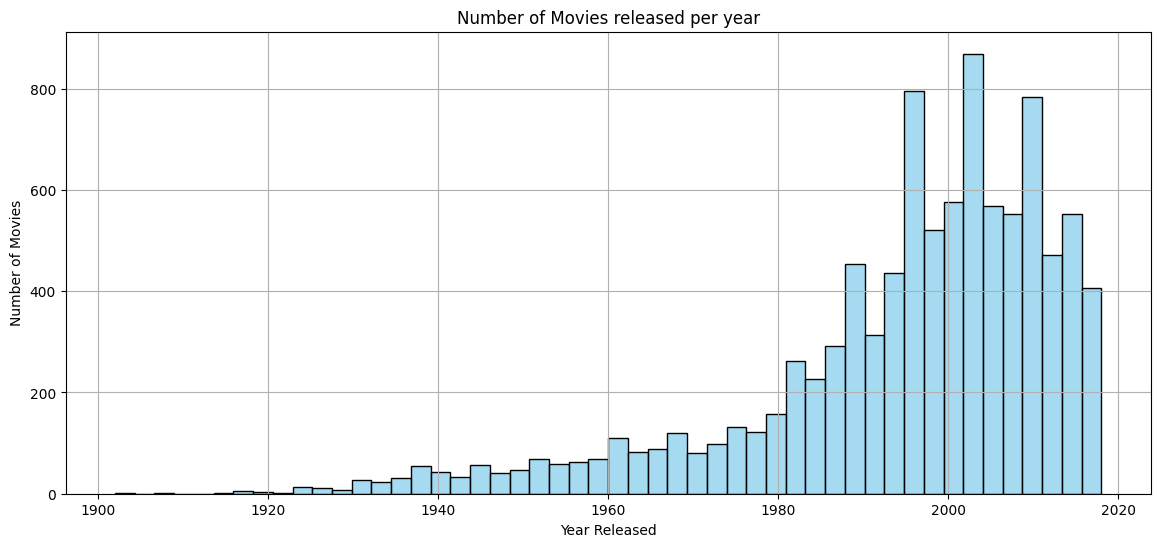

In [16]:
plt.figure(figsize=(14, 6))
sns.histplot(movies['year'], bins=50, kde=False, color='skyblue')
plt.title('Number of Movies released per year')
plt.xlabel('Year Released')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

## Distribution of Genres

In [17]:
top_genre_combos = movies['genres'].value_counts().head(10)
top_genre_combos

genres
Drama                   1052
Comedy                   946
Comedy|Drama             435
Comedy|Romance           363
Drama|Romance            349
Documentary              339
Comedy|Drama|Romance     276
Horror                   167
Drama|Thriller           167
Horror|Thriller          135
Name: count, dtype: int64

In [18]:
from collections import Counter

In [19]:
genre_list = movies['genres'].str.split('|').tolist()
flat_genre_list = [genre for sublist in genre_list for genre in sublist]
genre_counts = Counter(flat_genre_list)

In [20]:
genre_counts

Counter({'Drama': 4359,
         'Comedy': 3756,
         'Thriller': 1892,
         'Action': 1827,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Horror': 978,
         'Sci-Fi': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 25})

In [21]:
genre_df = pd.DataFrame(
    genre_counts.items(),
    columns=['Genre', 'Count'],
).sort_values(by='Count', ascending=False)

In [22]:
genre_df.head()

,Genre,Count
6,Drama,4359
3,Comedy,3756
9,Thriller,1892
7,Action,1827
5,Romance,1596


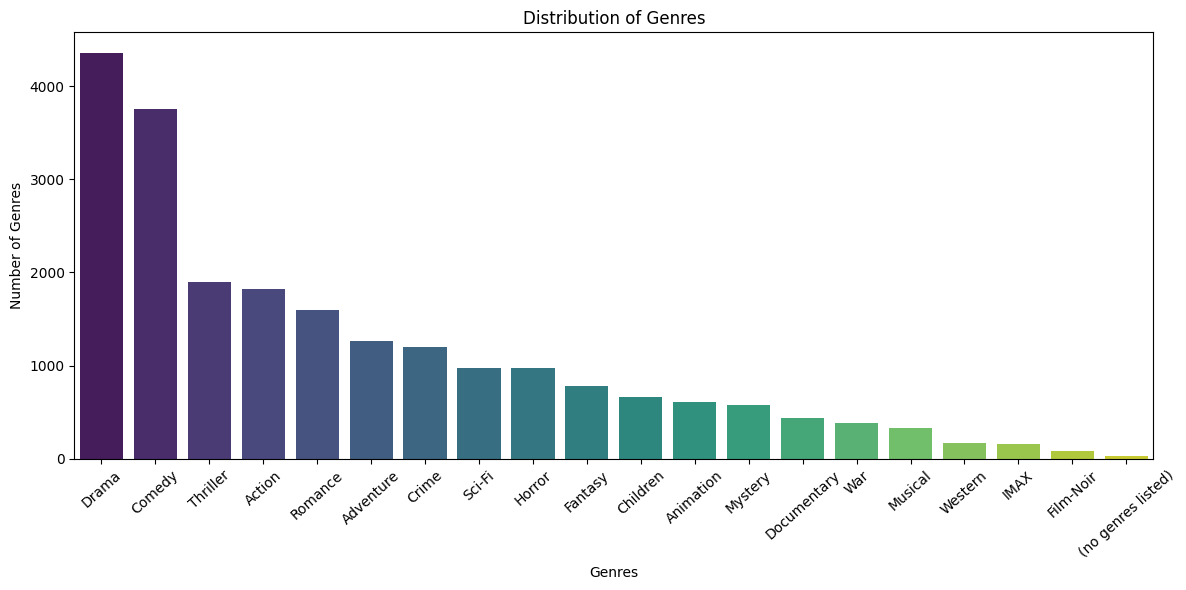

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df, x='Genre', y='Count', palette='viridis', hue='Genre', legend=False)
plt.title('Distribution of Genres')
plt.xlabel('Genres')
plt.ylabel('Number of Genres')
plt.xticks(rotation=42)
plt.tight_layout()
plt.show()

In [24]:
## Most common movies title
movies['clean_title'].value_counts().head()

clean_title
Hamlet                   5
Christmas Carol, A       4
Misérables, Les          4
Three Musketeers, The    4
Jane Eyre                4
Name: count, dtype: int64

## Feature Extraction using TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
movies['genres'] = movies['genres'].replace('(no genres listed)', '')

In [27]:
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [28]:
tfidf_matrix.shape

(9729, 21)

In [29]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [30]:
cosine_sim[:5, :5]

array([[1.        , 0.81358761, 0.15270449, 0.13507634, 0.26751064],
       [0.81358761, 1.        , 0.        , 0.        , 0.        ],
       [0.15270449, 0.        , 1.        , 0.88456037, 0.57083522],
       [0.13507634, 0.        , 0.88456037, 1.        , 0.50493821],
       [0.26751064, 0.        , 0.57083522, 0.50493821, 1.        ]])

## Build The Recommendation System

In [31]:
movies = movies.reset_index()

In [32]:
title_to_index = pd.Series(movies.index, index=movies['clean_title'].str.lower())
title_to_index

clean_title
toy story                                0
jumanji                                  1
grumpier old men                         2
waiting to exhale                        3
father of the bride part ii              4
                                      ... 
black butler: book of the atlantic    9724
no game no life: zero                 9725
flint                                 9726
bungo stray dogs: dead apple          9727
andrew dice clay: dice rules          9728
Length: 9729, dtype: int64

In [33]:
def recommend_movies(title, top_n=10):
    title = title.lower()
    if title not in title_to_index: 
        print(f"Movie {title} not found in the dataset.")
        return [] 

    idx = title_to_index[title] 
    sim_scores = list(enumerate(cosine_sim[idx]))

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    movies_indices = [i[0] for i in sim_scores]

    return movies[['clean_title', 'genres']].iloc[movies_indices]

In [34]:
recommendations = recommend_movies('Toy Story')
recommendations

,clean_title,genres
1706,Antz,Adventure|Animation|Children|Comedy|Fantasy
2355,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy
2809,"Adventures of Rocky and Bullwinkle, The",Adventure|Animation|Children|Comedy|Fantasy
3000,"Emperor's New Groove, The",Adventure|Animation|Children|Comedy|Fantasy
3568,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
6193,"Wild, The",Adventure|Animation|Children|Comedy|Fantasy
6485,Shrek the Third,Adventure|Animation|Children|Comedy|Fantasy
6947,"Tale of Despereaux, The",Adventure|Animation|Children|Comedy|Fantasy
7759,Asterix and the Vikings (Astérix et les Vikings),Adventure|Animation|Children|Comedy|Fantasy
8218,Turbo,Adventure|Animation|Children|Comedy|Fantasy


## Enrich Content for TF-IDF (Using Title + Genres)

In [35]:
movies['content'] = movies['clean_title'] + ' ' + movies['genres'].str.replace('|', ' ')

In [36]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['content'])

In [37]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [38]:
tfidf_matrix.shape

(9729, 8961)

In [39]:
title_to_index = pd.Series(movies.index, index=movies['clean_title'].str.lower())

In [40]:
def recommend_movies(title, top_n=10):
    title = title.lower()

    if title not in title_to_index: 
        print(f"Movie {title} not found in dataset")
        return []

    idx= title_to_index[title] 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]

    return movies[['clean_title', 'genres']].iloc[movie_indices]

In [41]:
recommend_movies('Toy Story')

,clean_title,genres
2355,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy
7354,Toy Story 3,Adventure|Animation|Children|Comedy|Fantasy|IMAX
3595,"Toy, The",Comedy
2539,We're Back! A Dinosaur's Story,Adventure|Animation|Children|Fantasy
2227,"Story of Us, The",Comedy|Drama
4089,Toy Soldiers,Action|Drama
7038,Up,Adventure|Animation|Children|Drama
1617,"NeverEnding Story, The",Adventure|Children|Fantasy
1570,L.A. Story,Comedy|Romance
6193,"Wild, The",Adventure|Animation|Children|Comedy|Fantasy


# Hybrid System (Content + Rating)

In [42]:
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [43]:
movie_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()

In [44]:
movie_ratings.columns = ['movieId', 'avg_ratings']

In [45]:
movie_ratings.head(3)

,movieId,avg_ratings
0,1,3.920930
1,2,3.431818
2,3,3.259615


In [46]:
movie_with_rating = pd.merge(movies, movie_ratings, on='movieId', how='left')

In [47]:
movie_with_rating.head()

,index,movieId,title,genres,year,clean_title,content,avg_ratings
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story,Toy Story Adventure Animation Children Comedy ...,3.920930
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji,Jumanji Adventure Children Fantasy,3.431818
2,2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men,Grumpier Old Men Comedy Romance,3.259615
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale,Waiting to Exhale Comedy Drama Romance,2.357143
4,4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II,Father of the Bride Part II Comedy,3.071429


In [48]:
movie_with_rating.isnull().sum()

index           0
movieId         0
title           0
genres          0
year            0
clean_title     0
content         0
avg_ratings    18
dtype: int64

In [49]:
movie_with_rating.fillna(0, inplace=True)

In [50]:
title_to_index.head()

clean_title
toy story                      0
jumanji                        1
grumpier old men               2
waiting to exhale              3
father of the bride part ii    4
dtype: int64

In [51]:
def hybrid_recommend(title, top_n= 10, alpha=0.7):
    titlee= title.lower()

    if title not in title_to_index: 
        print(f"Movie {title} not found in the dataset")
        return [] 

    idx = title_to_index[title] 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key= lambda x: x[1], reverse= True)[1:]

    hybrid_scores = [] 
    for i, scores in sim_scores: 
        rating = movie_with_rating.loc[i, 'avg_ratings'] 
        hybrid_score = alpha * scores + (1-alpha) * (rating/5.0)
        hybrid_scores.append((i, hybrid_score))

    hybrid_scores = sorted(hybrid_scores, key = lambda x: x[1], reverse=True)[:top_n]

    movie_indices = [i[0] for i in hybrid_scores]
    return movie_with_rating[['clean_title', 'genres', 'avg_ratings']].iloc[movie_indices]
    

In [52]:
hybrid_recommend("toy story")

,clean_title,genres,avg_ratings
2355,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy,3.860825
7354,Toy Story 3,Adventure|Animation|Children|Comedy|Fantasy|IMAX,4.109091
3595,"Toy, The",Comedy,2.375000
7038,Up,Adventure|Animation|Children|Drama,4.004762
2539,We're Back! A Dinosaur's Story,Adventure|Animation|Children|Fantasy,3.000000
2110,"Christmas Story, A",Children|Comedy,3.972727
1617,"NeverEnding Story, The",Adventure|Children|Fantasy,3.581395
9534,A Detective Story,Animation|Sci-Fi,5.000000
1570,L.A. Story,Comedy|Romance,3.479167
3568,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy,3.871212


# Personalized Hybrid Recommender

In [53]:
def personalized_hybrid(uder_id, top_n= 10): 
    user_ratings = ratings[ratings['userId'] == user_id]

    if user_ratings.empty: 
        print(f"No rating found for user {user_id}.")
        return [] 

    user_ratings = user_ratings.sort_values(by='rating', ascending=False)
    top_rated = user_ratings[user_ratings['rating'] >= 4.0]

    scores = {}

    for _, row in top_rated.iterrows(): 
        movie_id = row['movieId']
        rating = row['rating']

        if movie_id not in movie_with_rating['movieId'].values:
            continue

        idx = movie_with_rating[movie_with_rating['movieId'] == movie_id].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))

        for i, sim in sim_scores:
            movie_candidate_id = movie_with_rating.loc[i, 'movieId']
            if movie_candidate_id in user_ratings['movieId'].values: 
                continue

            if i not in scores:
                scores[i] = 0
            scores[i] += sim * rating

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    movie_indices = [i[0] for i in sorted_scores]
    return movie_with_rating[['clean_title', 'genres', 'avg_ratings']].iloc[movie_indices]

In [55]:
user_id = 5
personalized_hybrid(user_id)

,clean_title,genres,avg_ratings
7038,Up,Adventure|Animation|Children|Drama,4.004762
26,Now and Then,Children|Drama,3.333333
8056,Fire with Fire,Action|Crime|Drama,1.500000
9374,Your Name.,Animation|Drama|Fantasy|Romance,4.000000
6625,Enchanted,Adventure|Animation|Children|Comedy|Fantasy|Mu...,3.676471
5352,P.S.,Comedy|Drama|Fantasy|Romance,4.250000
8899,Inside Out,Adventure|Animation|Children|Comedy|Drama|Fantasy,3.813953
2355,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy,3.860825
7354,Toy Story 3,Adventure|Animation|Children|Comedy|Fantasy|IMAX,4.109091
1390,Mulan,Adventure|Animation|Children|Comedy|Drama|Musi...,3.566667
